<a href="https://colab.research.google.com/github/Jmerinom22/Codigo-Proyecto/blob/main/Modelo_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Base de datos **(La Paz)**

In [1]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

archivo = list(uploaded.keys())[0]
df = pd.read_csv(archivo, sep=';')  # Quien use este codigo asegúrate de usar el separador correcto

num_observaciones, num_variables = df.shape
print(f"Número de observaciones (filas): {num_observaciones}")
print(f"Número de variables (columnas): {num_variables}")

print("\n Lista de variables:")
print(df.columns.tolist())

Saving base_datos_solar_lapaz_2025 (1).csv to base_datos_solar_lapaz_2025 (1).csv
Número de observaciones (filas): 2880
Número de variables (columnas): 6

 Lista de variables:
['time', 'shortwave_radiation', 'temperature_2m', 'wind_speed_10m', 'relative_humidity_2m', 'energia_solar_kWh']


# Aproximaciones

## Modelo GCN

**¿Qué es una GNN?**

Una Graph Neural Network es un modelo que aprende de relaciones entre nodos conectados. Se usa mucho en:
- Redes sociales
- Mapas de carreteras
- Sensores climáticos conectados
- Predicción espacial-temporal

Nuestro datos actuales NO son un grafo

Actualmente tienemos una única estación de datos (La Paz) con valores horarios, no nodos conectados entre sí. Por lo tanto:

**Alternativa viable que tenemos es:**

Usar una GNN simplificada para series temporales:

- Creamos un grafo de tipo "lineal", donde cada instante de tiempo es un nodo conectado al anterior.
- Esto simula una secuencia temporal como una cadena de nodos.



**Instalamos `torch_geometric`**

In [2]:
#  Ejecutar solo en Colab (toma 1–2 minutos)
!pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 452.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.6 MB/s eta 0:00:00


### Preparar el grafo temporal

In [3]:
import pandas as pd

df = pd.read_csv("base_datos_solar_lapaz_2025 (1).csv", sep=';')
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

df['hora'] = df['time'].dt.hour
df['dia'] = df['time'].dt.day
df['mes'] = df['time'].dt.month
df['dia_del_año'] = df['time'].dt.dayofyear
df['dia_semana'] = df['time'].dt.dayofweek

df['energia_lag_1'] = df['energia_solar_kWh'].shift(1)
df['energia_lag_24'] = df['energia_solar_kWh'].shift(24)
df['energia_roll_3'] = df['energia_solar_kWh'].rolling(3).mean()

df = df.dropna()

X = df.drop(columns=['time', 'energia_solar_kWh', 'shortwave_radiation'])
y = df['energia_solar_kWh']

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

variables_usar = ['temperature_2m', 'wind_speed_10m', 'relative_humidity_2m',
                  'hora', 'dia_del_año', 'energia_solar_kWh']

datos = df[variables_usar].copy()

scaler = MinMaxScaler()
datos_scaled = scaler.fit_transform(datos)

def crear_secuencias(datos, ventana=24):
    X, y = [], []
    for i in range(ventana, len(datos)):
        X.append(datos[i-ventana:i, :])
        y.append(datos[i, -1])
    return np.array(X), np.array(y)

X_seq, y_seq = crear_secuencias(datos_scaled, ventana=24)

print(" Formato de X (samples, pasos, variables):", X_seq.shape)
print(" Formato de y:", y_seq.shape)

 Formato de X (samples, pasos, variables): (2832, 24, 6)
 Formato de y: (2832,)


In [5]:
n_muestras = X_seq.shape[0]
n_train = int(n_muestras * 0.8)

X_train, X_test = X_seq[:n_train], X_seq[n_train:]
y_train, y_test = y_seq[:n_train], y_seq[n_train:]

print(" X_train:", X_train.shape)
print(" X_test:", X_test.shape)
print(" y_train:", y_train.shape)
print(" y_test:", y_test.shape)

 X_train: (2265, 24, 6)
 X_test: (567, 24, 6)
 y_train: (2265,)
 y_test: (567,)


In [6]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np

X_gnn = X_seq.reshape(X_seq.shape[0], -1)
y_gnn = y_seq

x = torch.tensor(X_gnn, dtype=torch.float)
y = torch.tensor(y_gnn, dtype=torch.float).view(-1, 1)

edge_index = torch.tensor([
    [i, i+1] for i in range(x.size(0) - 1)
], dtype=torch.long).t().contiguous()

data = Data(x=x, y=y, edge_index=edge_index)

print(f" Nodos: {data.num_nodes}, Conexiones: {data.num_edges}")

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


 Nodos: 2832, Conexiones: 2831


Aunque hubo un warning de compatibilidad con las bibliotecas CUDA (torch-scatter y torch-sparse), el grafo fue creado correctamente:

- 2832 nodos (uno por cada hora)
- 2831 conexiones (una entre cada hora y la siguiente)

Esto es suficiente para continuar con un modelo GCN básico en CPU (funcionará igual aunque sea más lento).

### Construir el modelo GCN

Ahora creamos una red neuronal con 2 capas de tipo `GCNConv`:

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

modelo_gcn = GCN(in_channels=144, hidden_channels=64, out_channels=1)

optimizer = torch.optim.Adam(modelo_gcn.parameters(), lr=0.01)
loss_fn = nn.MSELoss()


### Entrenar el modelo GCN

Vamos a entrenar el modelo con todos los nodos del grafo (no se divide en entrenamiento/test explícitamente, porque los nodos ya están ordenados en el tiempo).

Aun así, tomaremos los últimos 20% de los nodos para evaluación.

In [13]:
for epoch in range(1, 201):
    modelo_gcn.train()
    optimizer.zero_grad()
    pred = modelo_gcn(data.x, data.edge_index)
    loss = loss_fn(pred, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0 or epoch == 1:
        print(f"🧪 Epoch {epoch}, Loss: {loss.item():.6f}")

n_test = int(len(data.y) * 0.2)
y_true_gcn = data.y[-n_test:].detach().numpy()
y_pred_gcn = pred[-n_test:].detach().numpy()

from sklearn.metrics import mean_squared_error, r2_score
rmse_gcn = np.sqrt(mean_squared_error(y_true_gcn, y_pred_gcn))
r2_gcn = r2_score(y_true_gcn, y_pred_gcn)

🧪 Epoch 1, Loss: 0.003445
🧪 Epoch 20, Loss: 0.003353
🧪 Epoch 40, Loss: 0.003264
🧪 Epoch 60, Loss: 0.003181
🧪 Epoch 80, Loss: 0.003104
🧪 Epoch 100, Loss: 0.003032
🧪 Epoch 120, Loss: 0.002965
🧪 Epoch 140, Loss: 0.002902
🧪 Epoch 160, Loss: 0.002842
🧪 Epoch 180, Loss: 0.002786
🧪 Epoch 200, Loss: 0.002733


In [14]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

print(f" RMSE (GCN): {rmse_gcn:.4f}")
print(f" R² (GCN): {r2_gcn:.4f}")
mae_gcn = mean_absolute_error(y_true_gcn, y_pred_gcn)
print(f" MAE (GCN): {mae_gcn:.4f}")

 RMSE (GCN): 0.0762
 R² (GCN): 0.9365
 MAE (GCN): 0.0458


- El GCN aprendió bien los patrones temporales, pero no tan fino como GRU o XGBoost.
- Como esperábamos, una GNN básica en una secuencia lineal no supera a modelos específicos de series como GRU o XGBoost con lags.
- Este resultado valida que las GNN pueden usarse, pero no son la mejor opción cuando no hay relaciones espaciales reales entre múltiples nodos (como estaciones climáticas conectadas).



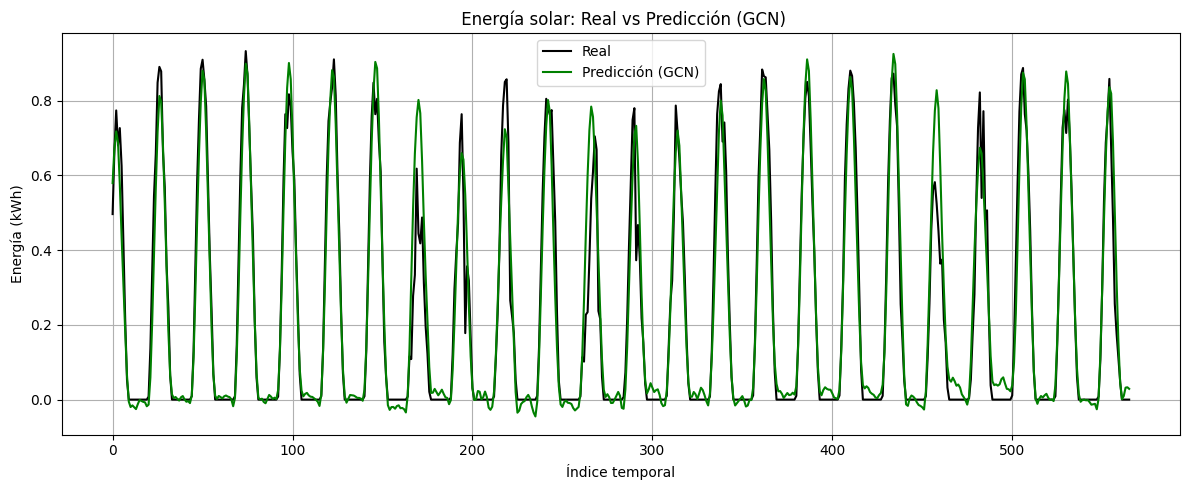

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(y_true_gcn, label='Real', color='black')
plt.plot(y_pred_gcn, label='Predicción (GCN)', color='green')
plt.title(" Energía solar: Real vs Predicción (GCN)")
plt.xlabel("Índice temporal")
plt.ylabel("Energía (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

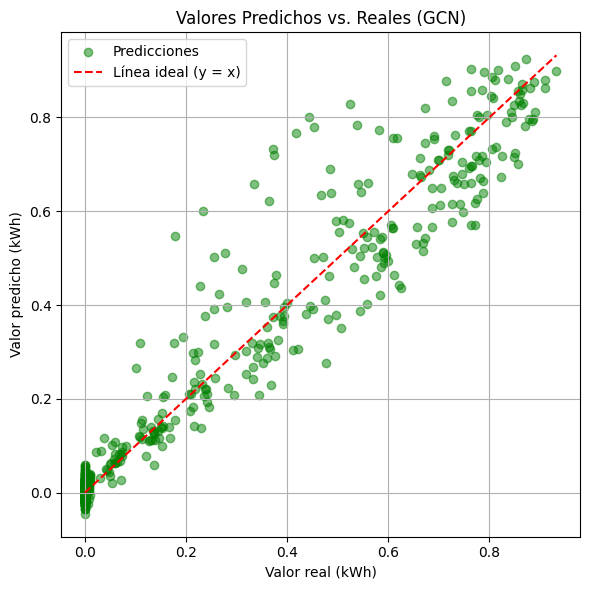

In [16]:
# Asegurar vectores planos para la gráfica
y_true_gcn_flat = y_true_gcn.ravel()
y_pred_gcn_flat = y_pred_gcn.ravel()

plt.figure(figsize=(6, 6))
plt.scatter(y_true_gcn_flat, y_pred_gcn_flat, color='green', alpha=0.5, label='Predicciones')
plt.plot([0, max(y_true_gcn_flat)], [0, max(y_true_gcn_flat)], 'r--', label='Línea ideal (y = x)')
plt.xlabel('Valor real (kWh)')
plt.ylabel('Valor predicho (kWh)')
plt.title('Valores Predichos vs. Reales (GCN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()